<a href="https://colab.research.google.com/github/MateoPeri/steel-scrap-predictor/blob/master/Steel%20Scrap%20Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import glob, os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import altair as alt
plt.style.use('seaborn-poster')

# Data preparation

In [5]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
!unzip {PATH}raw.zip -d {PATH}

--2020-06-13 15:35:46--  https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2543776 (2.4M) [application/zip]
Saving to: ‘/content/data/raw.zip’

raw.zip             100%[===================>]   2.43M  14.1MB/s    in 0.2s    

2020-06-13 15:35:48 (14.1 MB/s) - ‘/content/data/raw.zip’ saved [2543776/2543776]

Archive:  /content/data/raw.zip
   creating: /content/data/raw/
  inflating: /content/data/raw/CSF EOI.xlsx  
  inflating: /content/data/raw/CSF TV.xlsx  
  inflating: /content/data/raw/HC Closing Prices.xlsx  
  inflating: /content/data/raw/HC Final Settlement prices.xlsx  
  inflating: /content/data/raw/HU Closing Prices.xlsx  
  inflating: /content/data/raw/HU Final Settlemen

## Load dataset

In [0]:
def st_to_mt(st):
  return st/1.10231131

In [7]:
p = PATH+'raw/*Closing Prices.xlsx'
excels = glob.glob(p)

frames = []
to_keep = 'M1'

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  # le añadimos un nombre para saber qué metal es
  name = os.path.basename(xcel)[:2]
  if name == 'HU':
    # Seleccionar todas las columnas menos USD/st
    cols = [c for c in d.columns if c != 'USD/st (Short Ton)']
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    d[cols] = d[cols].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    d.rename({'USD/st (Short Ton)': 'USD/mt'}, axis=1, inplace=True)
  
  d.columns = ['Date'] + [name+'_'+c for c in d.columns if c != 'USD/mt']
  
  frames.append(df)

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames]
df = pd.concat(dfs, axis=1)

df.head()

,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,HU_M1,HU_M2,HU_M3,HU_M4,HU_M5,HU_M6,HU_M7,HU_M8,HU_M9,HU_M10,HU_M11,HU_M12,HU_M13,HU_M14,HU_M15,HC_M1,HC_M2,HC_M3,HC_M4,HC_M5,HC_M6,HC_M7,HC_M8,HC_M9,HC_M10,HC_M11,HC_M12,HC_M13,HC_M14,HC_M15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-11-23,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,338.0,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-24,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,337.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-25,195.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-26,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-27,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
p = PATH+'raw/CSF*.xlsx'

excels = glob.glob(p)

frames = []
to_keep = 'M1'

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  print(df.head())



         Contract code  ...                                                 UP
0             Lot size  ...                                              25 mt
1          Data format  ...                                               Lots
2        Contract name  ...  LME Aluminium Premium Duty Paid US Midwest (Pl...
3  2017-01-03 00:00:00  ...                                               n.a.
4  2017-01-04 00:00:00  ...                                               n.a.

[5 rows x 7 columns]
         Contract code  ...                                                 UP
0             Lot size  ...                                              25 mt
1          Data format  ...                                               Lots
2        Contract name  ...  LME Aluminium Premium Duty Paid US Midwest (Pl...
3  2017-01-03 00:00:00  ...                                               n.a.
4  2017-01-04 00:00:00  ...                                               n.a.

[5 rows x 7 columns]


In [12]:
# Cuando empiezan los valores de HU y HC -> 2019-03-11
#df = df.loc[df.HU_M1.notna() | df.HC_M1.notna()]
df = df.dropna()
df.index[0]

Timestamp('2019-03-11 00:00:00')

In [31]:
# Contamos los valores nulos del dataset -> 0
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2019-03-11 to 2020-05-05
Data columns (total 60 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SC_M1   292 non-null    float64
 1   SC_M2   292 non-null    float64
 2   SC_M3   292 non-null    float64
 3   SC_M4   292 non-null    float64
 4   SC_M5   292 non-null    float64
 5   SC_M6   292 non-null    float64
 6   SC_M7   292 non-null    float64
 7   SC_M8   292 non-null    float64
 8   SC_M9   292 non-null    float64
 9   SC_M10  292 non-null    float64
 10  SC_M11  292 non-null    float64
 11  SC_M12  292 non-null    float64
 12  SC_M13  292 non-null    float64
 13  SC_M14  292 non-null    float64
 14  SC_M15  292 non-null    float64
 15  SR_M1   292 non-null    float64
 16  SR_M2   292 non-null    float64
 17  SR_M3   292 non-null    float64
 18  SR_M4   292 non-null    float64
 19  SR_M5   292 non-null    float64
 20  SR_M6   292 non-null    float64
 21  SR_M7   292 non-null

# Data visualization

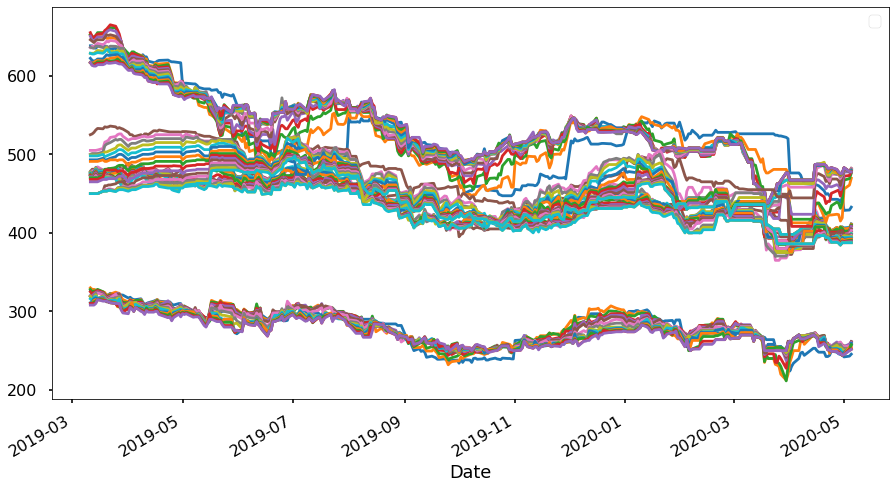

In [32]:
fig, ax = subplots()
df.plot(figsize=(15,8), ax=ax)
ax.legend([]);

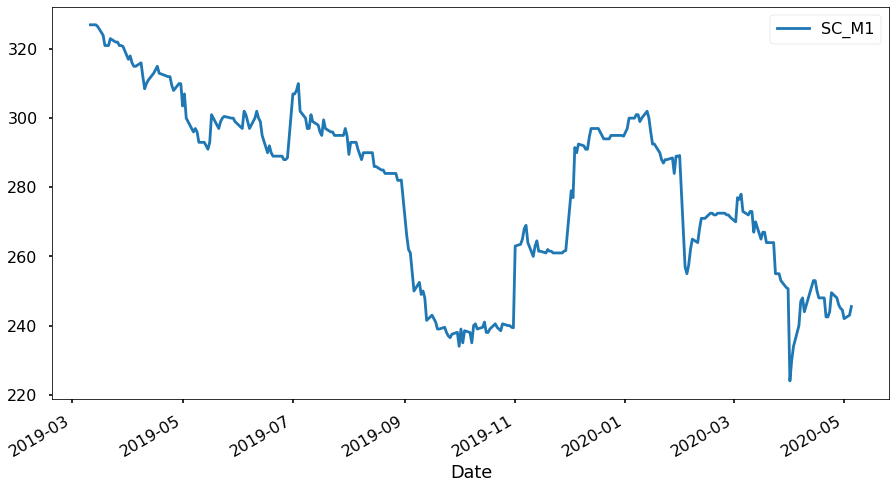

In [33]:
df[['SC_M1']].plot(figsize=(15,8))

# Model

In [0]:
to_predict = 'SC_M1'
data = df.reset_index().copy()

In [0]:
def add_caps(d1, d2=None, c='y'):
  if d2 is None:
    d2 = d1
  d2['cap'] = d1[c].max()
  d2['floor'] = d1[c].min()
  return d2

In [44]:
print(df[[c for c in df.columns if c not in ['Date', to_predict]]].head())

            SC_M2  SC_M3  SC_M4  SC_M5  ...  HC_M12  HC_M13  HC_M14  HC_M15
Date                                    ...                                
2019-03-11  330.0  328.0  325.0  320.0  ...   450.0   450.0   450.0   450.0
2019-03-12  328.0  325.0  322.0  319.0  ...   450.0   450.0   450.0   450.0
2019-03-13  328.0  326.0  324.0  322.0  ...   450.0   450.0   450.0   450.0
2019-03-14  327.0  326.0  325.0  324.0  ...   450.0   450.0   450.0   450.0
2019-03-15  327.0  328.0  326.5  325.0  ...   450.0   450.0   450.0   450.0

[5 rows x 59 columns]


In [0]:
def generate_model(dff):
  fecha = '2019-03-11'

  others = dff[[c for c in df.columns if c not in ['Date', to_predict]]].columns
  dff.rename({'Date': 'ds', to_predict: 'y'}, axis=1, inplace=True)
  #dff = dff[['ds', 'y']]

  dff = dff.loc[dff.ds > fecha].copy()
  dff = add_caps(dff)
  modelo_futuro = Prophet(growth='linear', seasonality_mode='additive', yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)
  for o in others:
    modelo_futuro.add_regressor(o)
  print('Added', len(others), 'regressors')
  return modelo_futuro, dff

In [46]:
model, df_pred = generate_model(data)
df_pred.head()

Index(['SC_M2', 'SC_M3', 'SC_M4', 'SC_M5', 'SC_M6', 'SC_M7', 'SC_M8', 'SC_M9',
       'SC_M10', 'SC_M11', 'SC_M12', 'SC_M13', 'SC_M14', 'SC_M15', 'SR_M1',
       'SR_M2', 'SR_M3', 'SR_M4', 'SR_M5', 'SR_M6', 'SR_M7', 'SR_M8', 'SR_M9',
       'SR_M10', 'SR_M11', 'SR_M12', 'SR_M13', 'SR_M14', 'SR_M15', 'HU_M1',
       'HU_M2', 'HU_M3', 'HU_M4', 'HU_M5', 'HU_M6', 'HU_M7', 'HU_M8', 'HU_M9',
       'HU_M10', 'HU_M11', 'HU_M12', 'HU_M13', 'HU_M14', 'HU_M15', 'HC_M1',
       'HC_M2', 'HC_M3', 'HC_M4', 'HC_M5', 'HC_M6', 'HC_M7', 'HC_M8', 'HC_M9',
       'HC_M10', 'HC_M11', 'HC_M12', 'HC_M13', 'HC_M14', 'HC_M15'],
      dtype='object')
Added 59 regressors


,ds,y,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,HU_M1,HU_M2,HU_M3,HU_M4,HU_M5,HU_M6,HU_M7,HU_M8,HU_M9,HU_M10,HU_M11,HU_M12,HU_M13,HU_M14,HU_M15,HC_M1,HC_M2,HC_M3,HC_M4,HC_M5,HC_M6,HC_M7,HC_M8,HC_M9,HC_M10,HC_M11,HC_M12,HC_M13,HC_M14,HC_M15,cap,floor
1,2019-03-12,327.0,328.0,325.0,322.0,319.0,316.0,314.0,314.0,314.0,314.0,312.0,310.0,310.0,310.0,308.0,481.0,479.0,477.0,475.0,473.0,471.0,469.5,470.0,471.0,472.0,471.0,470.0,470.0,470.0,470.0,638.204465,648.637090,650.451459,649.997867,645.461943,644.101166,637.750873,635.482911,628.679025,627.771841,619.607178,615.978439,615.071254,613.710477,613.256885,526.0,505.0,501.0,499.0,498.0,493.0,491.0,470.0,468.0,465.0,450.0,450.0,450.0,450.0,450.0,327.0,224.0
2,2019-03-13,327.0,328.0,326.0,324.0,322.0,319.5,318.0,318.0,318.0,318.0,316.0,314.0,312.0,310.0,308.0,481.0,479.0,477.0,475.0,476.0,477.5,475.0,474.0,473.0,472.0,471.0,470.0,469.0,469.0,469.0,636.843688,647.729905,648.637090,648.637090,644.101166,642.286796,636.843688,635.029319,628.679025,627.771841,618.699993,616.885624,615.071254,613.256885,612.349700,528.0,505.0,501.0,499.0,498.0,493.0,491.0,470.0,468.0,465.0,450.0,450.0,450.0,450.0,450.0,327.0,224.0
3,2019-03-14,327.0,327.0,326.0,325.0,324.0,323.0,323.0,323.0,321.0,319.0,317.0,315.0,313.0,311.0,310.0,481.0,482.0,483.5,482.0,481.0,480.0,479.0,478.0,477.5,476.5,475.0,473.0,471.0,469.0,469.0,635.029319,650.451459,651.358644,651.358644,646.822720,645.008351,639.565242,637.750873,630.493395,628.679025,619.607178,618.699993,615.978439,615.071254,612.349700,531.0,505.0,501.0,499.0,498.0,493.0,491.0,470.0,468.0,465.0,450.0,450.0,450.0,450.0,450.0,327.0,224.0
4,2019-03-15,326.5,327.0,328.0,326.5,325.0,324.0,323.5,316.0,316.0,316.0,316.0,315.0,315.0,315.0,315.0,476.0,484.0,480.0,475.0,478.5,476.0,474.0,474.0,473.0,472.0,471.0,470.0,469.0,469.0,469.0,637.750873,651.358644,654.987383,653.173013,649.544274,645.915535,641.379612,637.750873,632.307764,629.586210,621.421547,619.607178,617.792808,615.978439,614.164069,533.0,505.5,501.0,499.0,498.0,493.0,491.0,470.0,468.0,465.0,450.0,450.0,450.0,450.0,450.0,327.0,224.0
5,2019-03-18,324.0,325.0,325.0,324.0,323.0,322.0,321.0,320.0,319.0,318.0,317.0,316.0,315.0,314.0,313.0,479.0,480.0,480.0,479.0,478.0,477.0,476.0,475.0,474.0,473.0,472.0,471.0,470.0,470.0,470.0,639.565242,653.173013,654.987383,654.080198,649.544274,645.915535,639.565242,635.936503,631.400580,628.679025,621.421547,618.699993,617.792808,615.978439,614.164069,532.5,507.5,503.0,501.0,500.0,495.0,493.0,473.0,471.0,468.0,453.0,453.0,453.0,453.0,453.0,327.0,224.0


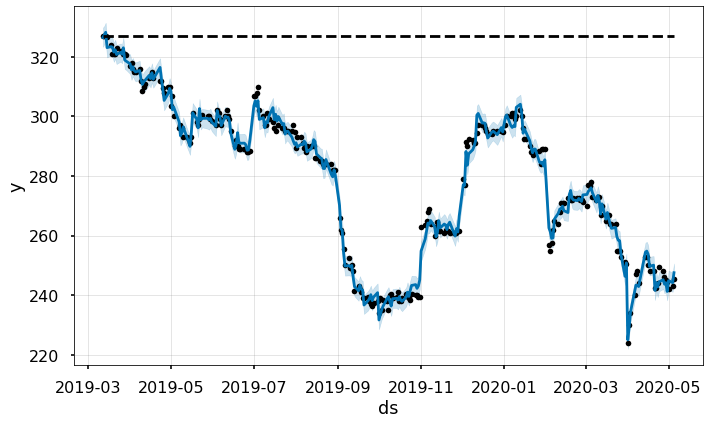

In [47]:
model.fit(df_pred)
forecast = model.predict(df_pred)
fig = model.plot(forecast)

In [48]:
forecast['fact'] = df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(forecast.fact, forecast.yhat)*100))

Accuracy: 99.05%


# Predict Future [EN PROCESO]

In [0]:
# 3 more months from end of data
future = model.make_future_dataframe(periods=730, freq='d')
future = add_caps(df_pred, future)

In [69]:
future.tail()

,ds,cap,floor
1016,2022-05-01,327.0,224.0
1017,2022-05-02,327.0,224.0
1018,2022-05-03,327.0,224.0
1019,2022-05-04,327.0,224.0
1020,2022-05-05,327.0,224.0


In [70]:
future_forecast = model.predict(future)
fig = model.plot(future_forecast)

ValueError: ignored

In [51]:
future_forecast['fact'] = future['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(future_forecast.fact, future_forecast.yhat)*100))

Accuracy: 99.05%
